In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [13]:
# Define Bayesian MLP
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, num_classes=1, dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.net(x).squeeze()

In [14]:
# Load Data
train_features, train_labels = torch.load("features_train_full.pt")
val_features, val_labels = torch.load("features_val_full.pt")
test_features, test_labels = torch.load("features_test_full.pt")


In [15]:
# Datasets and Dataloaders
train_ds = TensorDataset(train_features, train_labels.float())
val_ds = TensorDataset(val_features, val_labels.float())
test_ds = TensorDataset(test_features, test_labels.float())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [16]:
# Initialize Model
input_dim = train_features.shape[1]
model = BayesianMLP(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.BCELoss()

In [17]:
# Training Loop
train_losses, val_losses = [], []
for epoch in range(20):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation (using val_loader)
    model.eval()
    with torch.no_grad():
        val_epoch_loss = 0
        for xb, yb in val_loader:
            val_pred = model(xb)
            val_epoch_loss += criterion(val_pred, yb).item()
        val_losses.append(val_epoch_loss / len(val_loader))

    print(f"Epoch {epoch+1:02d}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

Epoch 01: Train Loss = 0.1648, Val Loss = 0.0569
Epoch 02: Train Loss = 0.0810, Val Loss = 0.0417
Epoch 03: Train Loss = 0.0720, Val Loss = 0.0347
Epoch 04: Train Loss = 0.0635, Val Loss = 0.0337
Epoch 05: Train Loss = 0.0550, Val Loss = 0.0335
Epoch 06: Train Loss = 0.0573, Val Loss = 0.0271
Epoch 07: Train Loss = 0.0461, Val Loss = 0.0271
Epoch 08: Train Loss = 0.0456, Val Loss = 0.0223
Epoch 09: Train Loss = 0.0459, Val Loss = 0.0281
Epoch 10: Train Loss = 0.0361, Val Loss = 0.0213
Epoch 11: Train Loss = 0.0350, Val Loss = 0.0202
Epoch 12: Train Loss = 0.0329, Val Loss = 0.0209
Epoch 13: Train Loss = 0.0256, Val Loss = 0.0198
Epoch 14: Train Loss = 0.0279, Val Loss = 0.0199
Epoch 15: Train Loss = 0.0267, Val Loss = 0.0206
Epoch 16: Train Loss = 0.0270, Val Loss = 0.0171
Epoch 17: Train Loss = 0.0273, Val Loss = 0.0200
Epoch 18: Train Loss = 0.0238, Val Loss = 0.0170
Epoch 19: Train Loss = 0.0238, Val Loss = 0.0179
Epoch 20: Train Loss = 0.0253, Val Loss = 0.0182


In [18]:
# Evaluation Function
def evaluate_model(model, features, labels, num_samples=30):
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()
    preds = [model(features) for _ in range(num_samples)]
    mean_pred = torch.stack(preds).mean(dim=0)
    pred_labels = (mean_pred >= 0.5).long()
    acc = accuracy_score(labels, pred_labels)
    prec = precision_score(labels, pred_labels)
    rec = recall_score(labels, pred_labels)
    cm = confusion_matrix(labels, pred_labels)
    return acc, prec, rec, cm, mean_pred

In [19]:
# Run Evaluation
acc, prec, rec, cm, _ = evaluate_model(model, test_features, test_labels)
print(f"Final Evaluation\nAccuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}")
print("Confusion Matrix:\n", cm)

Final Evaluation
Accuracy: 0.9917
Precision: 0.9849
Recall: 0.9783
Confusion Matrix:
 [[2049    9]
 [  13  587]]


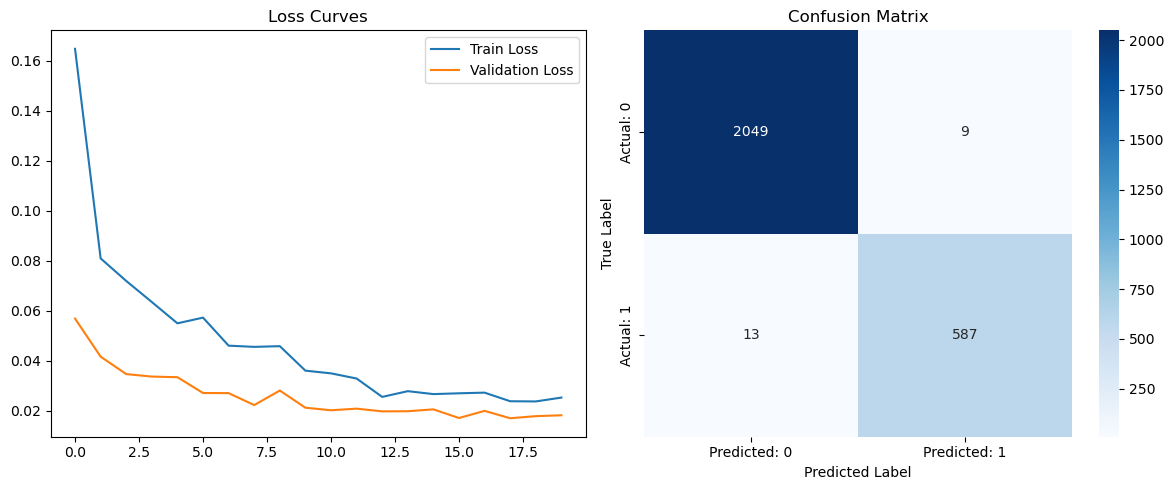

In [20]:
# Plot Result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].legend()
axs[0].set_title("Loss Curves")

# Replace imshow with seaborn heatmap for confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()